# 1. Import library

In [1]:
import numpy as np
import pandas as  pd
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,  confusion_matrix, recall_score, precision_score, f1_score

import re
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.api import layers

from transformers import GPT2Tokenizer

# 2. Read Data

In [2]:
csv_path = "./data.csv"

In [3]:
df = pd.read_csv(csv_path)
df

,Sentiment,Review,label,num_character,num_of_word,num_sentences
0,nv_tot,Nhân viên luôn nhiệt tình và thân thiện với kh...,0,55,12,1
1,nv_tot,Tôi thực sự ấn tượng với sự chuyên nghiệp của ...,0,62,15,1
2,nv_tot,Tôi thực sự ấn tượng với sự chuyên nghiệp của ...,0,65,15,1
3,nv_tot,Nhân viên rất nhiệt tình và thân thiện với mọi...,0,62,14,1
4,nv_tot,Dịch vụ tuyệt vời và nhân viên luôn sẵn sàng g...,0,70,17,1
...,...,...,...,...,...,...
1232,sp_xau,"""Dây đeo rất cứng và thô, đeo vào tay cảm thấy...",5,65,17,1
1233,sp_xau,""" chất lượng sản phẩm tuyệt vời . thời gian gi...",5,122,32,3
1234,sp_xau,""" lon nào cũng bị mốp vỏ hết ""\n",5,31,9,1
1235,sp_xau,"""Chưa lột sạch mụn hẳn ""\n",5,25,7,1


In [4]:
CLASS_NAMES = list(df["Sentiment"].unique())
CLASS_NAMES

['nv_tot', 'nv_xau', 'shop_tot', 'shop_xau', 'sp_tot', 'sp_xau']

# 3. Data preprocessing

## 3.2. Counting missing value in the dataset

In [5]:
df.isnull().sum()

Sentiment        0
Review           0
label            0
num_character    0
num_of_word      0
num_sentences    0
dtype: int64

## 3.2 Replacing null value to empty string

In [6]:
df = df.fillna("")

In [7]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ').replace("\n", "  ")
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x
df['Review'] = df['Review'].map(get_clean)

# 4. EDA

## 4.1 Distribution of Sentiment

In [8]:
df['Sentiment'].value_counts()

Sentiment
sp_tot      425
sp_xau      271
shop_tot    171
nv_tot      147
shop_xau    119
nv_xau      104
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x14342b9e450>,
 [Text(0.5190753071914023, 0.9698251520063561, 'sp_tot'),
  Text(-1.052609013964132, 0.31939671839494244, 'sp_xau'),
  Text(-0.7440356121879522, -0.8101919573755959, 'shop_tot'),
  Text(0.07118841616139998, -1.0976940418005516, 'nv_tot'),
  Text(0.741975573587639, -0.8120789667263242, 'shop_xau'),
  Text(1.061852735844376, -0.2871737581670971, 'nv_xau')],
 [Text(0.28313198574076487, 0.5289955374580123, '34.36'),
  Text(-0.5741503712531628, 0.17421639185178675, '21.91'),
  Text(-0.4058376066479739, -0.44192288584123407, '13.82'),
  Text(0.038830045178945435, -0.5987422046184827, '11.88'),
  Text(0.40471394922962123, -0.44295216366890405, '9.62'),
  Text(0.5791924013696594, -0.15664023172750752, '8.41')])

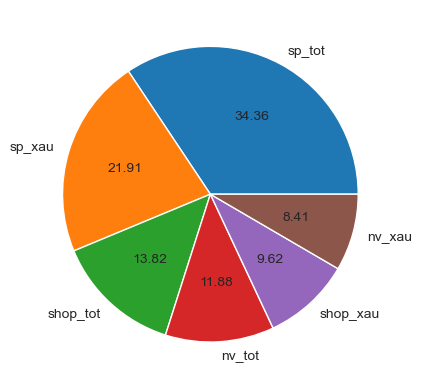

In [9]:
sentiment_counts = df['Sentiment'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%0.2f')

## 4.2. Distribution of num character for each sentiment

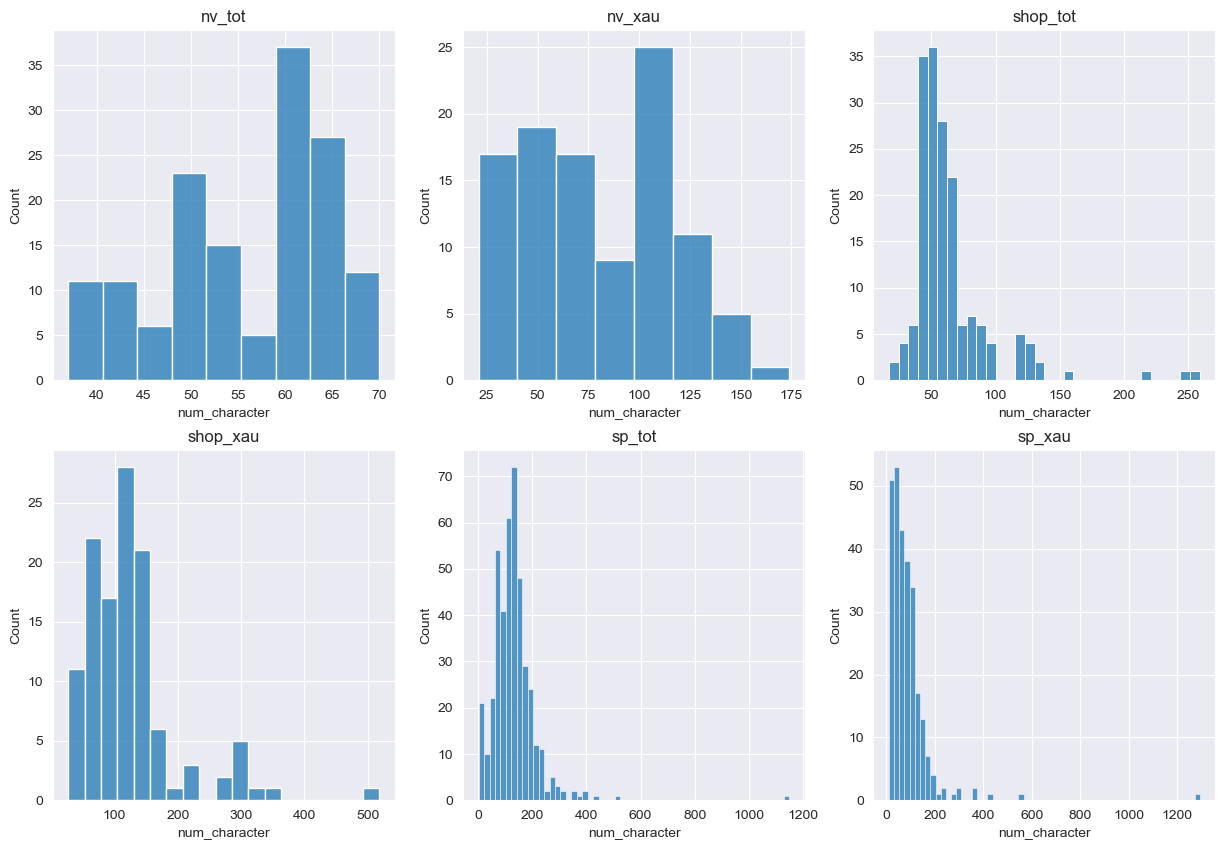

In [10]:
plt.figure(figsize=(15, 10))
for i in range(len(CLASS_NAMES)):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df[df['Sentiment']==CLASS_NAMES[i]], x="num_character")
    plt.title(CLASS_NAMES[i])

C:\Users\ad\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x500 with 0 Axes>

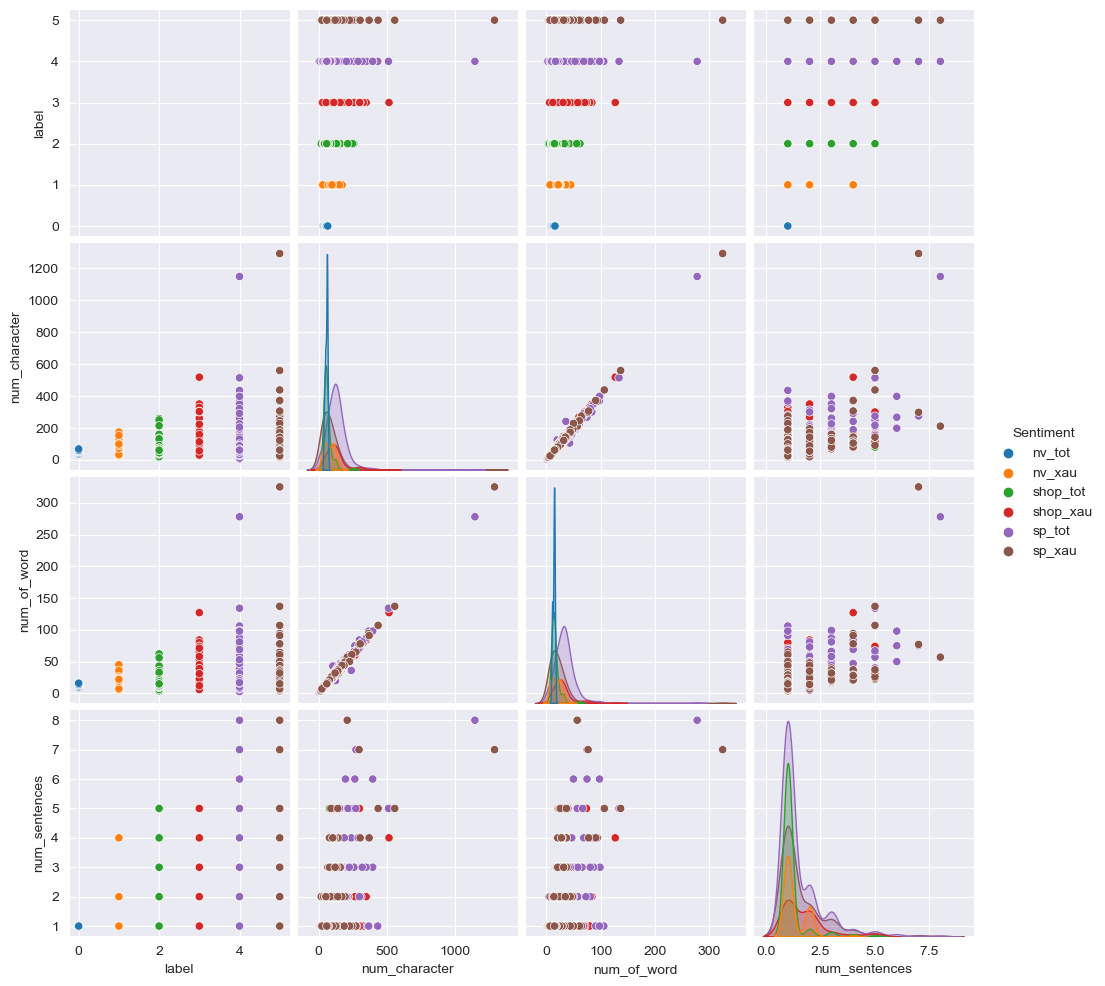

In [11]:
plt.figure(figsize=[15,5])
sns.pairplot(df, hue='Sentiment')

# 5. Tokenizer

## 5.1 Get all review and find max length

In [12]:
list_review = df['Review'].to_list()

In [13]:
max_length = max(len(x.split(" ")) for x in list_review)
print(max_length)

293


## 5.2 Download vietnamese tokenizer

In [14]:
tokenizer = GPT2Tokenizer.from_pretrained('NlpHUST/gpt2-vietnamese')
tokenizer.pad_token = tokenizer.eos_token
vocab = tokenizer.get_vocab()

## 5.3 Covert list of text to list of sequences

In [15]:
sequences = tokenizer.batch_encode_plus( list_review,
    add_special_tokens=True,
    padding='longest',      
    truncation=True,         
    max_length=max_length,            
    return_tensors='tf',
                                         
)['input_ids'].numpy()

In [16]:
print(list_review[0])
print(sequences[0])

nhân viên luôn nhiệt tình và thân thiện với khách hàng.
[ 5319   658   960  1414   758   309   943  1377   370   637   498    18
 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257
 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257
 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257
 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257
 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257
 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257
 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257
 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257
 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257
 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257
 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257
 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 50257 5

In [17]:
print(tokenizer.decode(sequences[0], skip_special_tokens=True))

nhân viên luôn nhiệt tình và thân thiện với khách hàng.


# 6 Create dataset 

## 6.1 Splitting dataset

In [18]:
x_train, x_test, y_train, y_test = train_test_split(sequences, df['label'].to_list(), test_size=0.2, random_state=0)

## 6.2 Covert int to one hot

In [19]:
y_train_onehot = keras.utils.to_categorical(y_train, num_classes=6)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes=6)

## 6.3  Add one dimension for features

In [20]:
x_train = tf.reshape(x_train, (*x_train.shape, 1))
x_test = tf.reshape(x_test, (*x_test.shape, 1))

## 6.4 Covert numpy to tf dataset from optimization training process

In [21]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_onehot)).batch(8).cache().shuffle(buffer_size=len(x_train)//8)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_onehot)).batch(8).cache().shuffle(buffer_size=len(x_test)//8)

## 6.5 Testing tf dataset

In [22]:
for batch in train_ds.take(1):
    for seq, label in zip(batch[0], batch[1]):
        seq = seq.numpy()
        label = label.numpy().argmax()
        review =  tokenizer.decode(seq.reshape(max_length, ), skip_special_tokens=True)
        sentiment = CLASS_NAMES[label]
        
        print(f"{review} => {sentiment}({label})\n")    
    

siêu rẻ, dùng ổn, 5 sao, ko đủ 60 kg, mà 60 kg cũng ko cần thiết, chả mấy ai bóp đc từng đó, bấm số ngon, nói chung là rất rẻ, nên mua tập tay => sp_tot(4)

chất lượng sản phẩm: tốt mẫu mã đẹp  chất liệu: cotton  đúng với mô tả: đúng với mô tả  giá cả hợp lý, màu sắc rất đẹp, bộ ga gối này mình rất thích => sp_tot(4)

shop giao hàng không đúng hình ảnh thực tế. báo cáo sản phẩm thì shop kiếm chuyện. mọi người nên chú ý shop nhé. quạt giao giá thành bằng nửa giá đặt. cho 1 sao.  => shop_xau(3)

tôi thực sự ấn tượng với dịch vụ tận tâm của nhân viên. => nv_tot(0)

nhân viên không biết cách sử dụng hệ thống điểm thưởng.   => nv_xau(1)

nhân viên không thể đáp ứng các yêu cầu đặc biệt của khách hàng, ví dụ như giao hàng tận nơi, đổi trả sản phẩm đã qua sử dụng.   => nv_xau(1)

nhân viên không giải thích rõ ràng.   => nv_xau(1)

đúng với mô tả: hưng  chất lượng sản phẩm: 5 sao  tốt mình rất ưng hãy ủng hộ sop nhé  cầm rất chắc tay rất êm nhẹ => sp_tot(4)


## 6.6 Splitting train ds to train and val

In [23]:
val_size = int(len(train_ds)*0.2)
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

# 7. Classification sentiment model

## 7.1. Build model

In [24]:
_input =layers.Input(shape=(max_length, ), name="input")
x =layers.Embedding(input_dim=len(vocab), output_dim=768, name="embedding")(_input)
x =layers.Bidirectional(layers.LSTM(256, name='lstm', return_sequences=True), merge_mode='mul')(x)
x = layers.Flatten()(x)
x =layers.Dropout(0.5, name="dropout")(x)
x =layers.Dense(128, activation='relu', name="fc_1")(x)
x =layers.Dense(32, activation='relu', name="fc_2")(x)
x =layers.Dense(6, activation='softmax', name="output")(x)
model = keras.Model(inputs=[_input], outputs=[x], name="sentiments_model")

## 7.2 Show information of model 

In [25]:
model.summary()

Model: "sentiments_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 293)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 293, 768)       │    38,598,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 293, 256)       │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 75008)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75008)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 128)            │     9,601,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,302,822 (191.89 MB)

 Trainable params: 50,302,822 (191.89 MB)

 Non-trainable params: 0 (0.00 B)

## 7.3 Compile loss, optimizer and metrics for training process

In [26]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-4),
    metrics = ['accuracy']
)

# 8. Training 

In [27]:
EPOCHS = 100

## 8.1 Download weight of model on google drive

In [28]:
import gdown
weight_path = f"./weights_sentiment_model.h5"
def download_weights(weights_path):
    if not os.path.exists(weights_path):
        file_id = '13ZG5HOVqf6QY7TyPDiEAyjzpSq1IwJc2'
        url = f'https://drive.google.com/uc?id={file_id}'
        gdown.download(url, weights_path, quiet=False)
download_weights(weight_path)

Downloading...
From (original): https://drive.google.com/uc?id=13ZG5HOVqf6QY7TyPDiEAyjzpSq1IwJc2
From (redirected): https://drive.google.com/uc?id=13ZG5HOVqf6QY7TyPDiEAyjzpSq1IwJc2&confirm=t&uuid=e70358d4-aa0c-4a63-87ec-d8c4c3470220
To: D:\workspace\Python\Deep_learning\Projects\SIC\sentiment_transformer\tinh\weights_sentiment_model.h5
100%|██████████| 201M/201M [01:42<00:00, 1.96MB/s] 


In [29]:
if os.path.exists(weight_path):
    model.load_weights(weight_path)
else:
    hist = model.fit(train_ds, batch_size=8, epochs=EPOCHS, validation_data=val_ds)

# 9. Evaluate

## 9.1 Loss and accuracy in training process

In [30]:
try:
    history = hist.history
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    train_loss = history['loss']
    val_loss = history['val_loss']
    
    labels = ['Training', 'Validation']
    data_plot = [{
        'title' : 'Accuracy',
        'train_data' : train_acc,
        'val_data' : val_acc
        
    }, {
        'title' : 'Loss',
        'train_data' : train_loss,
        'val_data' : val_loss
        
    }
    ]
    plt.figure(figsize=(12, 8))
    for i in range(len(data_plot)):
        plt.subplot(2, 1, i+1)
        plt.plot(range(EPOCHS), data_plot[i]['train_data'], label=labels[0])
        plt.plot(range(EPOCHS), data_plot[i]['val_data'], label=labels[1])
        plt.title(f'Training and Validation {data_plot[i]["title"]}')
        plt.legend( loc='lower right' if i == 0 else 'upper right')
except:
    print("Don't have any training process")

Don't have any training process


## 9.2. Accuracy and top 5 accuracy

In [31]:
def calculate_accuracy_and_top5(model, dataset):
    
    accuracy_metric = keras.metrics.CategoricalAccuracy()
    top5_accuracy_metric = keras.metrics.TopKCategoricalAccuracy(k=5)

    for feature, labels in dataset:
        predictions = model(feature, training=False)
        accuracy_metric.update_state(labels, predictions)
        top5_accuracy_metric.update_state(labels, predictions)

    accuracy = accuracy_metric.result().numpy()
    top5_accuracy = top5_accuracy_metric.result().numpy()

    return accuracy, top5_accuracy

accuracy, top5_acc = calculate_accuracy_and_top5(model, test_ds)
    
print(f"Accuracy: {accuracy}")
print(f"Top-5 Accuracy: {top5_acc}")

Accuracy: 0.9112903475761414
Top-5 Accuracy: 1.0


Macro Recall: 0.9198169161606561
Micro Recall: 0.9112903225806451
Macro Precision: 0.9052526044914827
Micro Precision: 0.9112903225806451


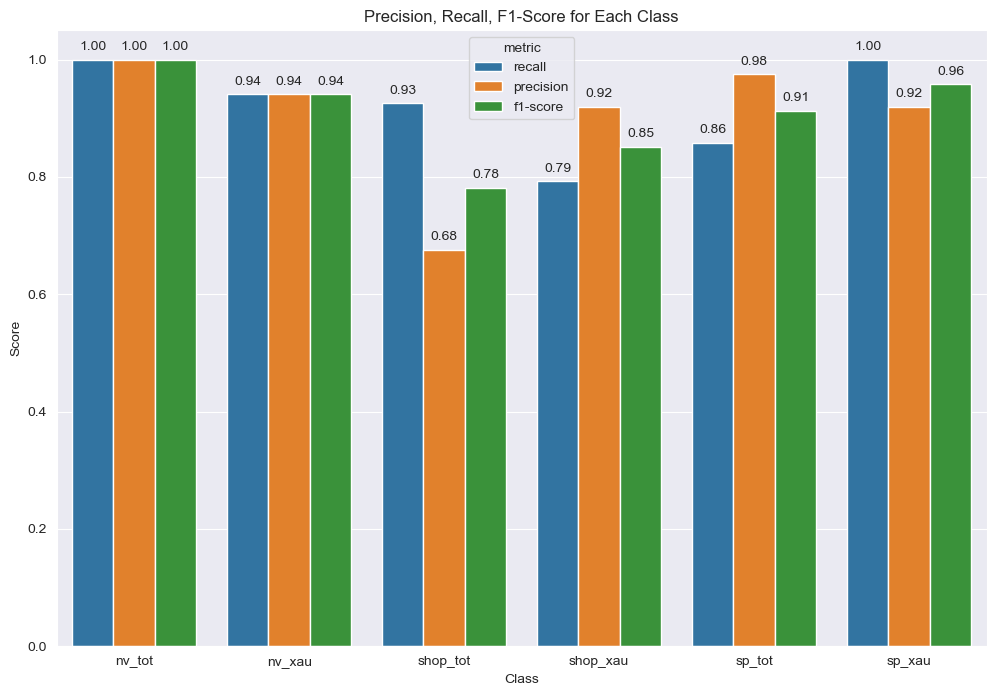

In [39]:
def visualize_metrics(dataset):
    y_true = []
    y_pred = []
    for seqs, labels in dataset:
        predictions = model.predict(seqs, verbose=False)
        
        y_true.extend(labels.numpy().argmax(axis=1))
        y_pred.extend(predictions.argmax(axis=1))
    
    print(f"Macro Recall: {recall_score(y_true, y_pred, average='macro')}")    
    print(f"Micro Recall: {recall_score(y_true, y_pred, average='micro')}")
    
    print(f"Macro Precision: {precision_score(y_true, y_pred, average='macro')}")    
    print(f"Micro Precision: {precision_score(y_true, y_pred, average='micro')}")
    
    df_metrics = pd.DataFrame({
        "class": CLASS_NAMES,
        "recall": recall_score(y_true, y_pred, average=None),
        "precision": precision_score(y_true, y_pred, average=None),
        "f1-score": f1_score(y_true, y_pred, average=None),
    })
    df_metrics = df_metrics.melt(id_vars="class", value_vars=["recall", "precision", "f1-score"], var_name="metric", value_name="value")
    
    plt.figure(figsize=(12, 8))
    barplot = sns.barplot(data=df_metrics, x="class", y="value", hue="metric")
    plt.title('Precision, Recall, F1-Score for Each Class')
    plt.xlabel('Class')
    plt.ylabel('Score')
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.2f'),
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha = 'center', va = 'center',
                         xytext = (0, 9),
                         textcoords = 'offset points')
    plt.show()
visualize_metrics(test_ds)

## 9.3 ROC

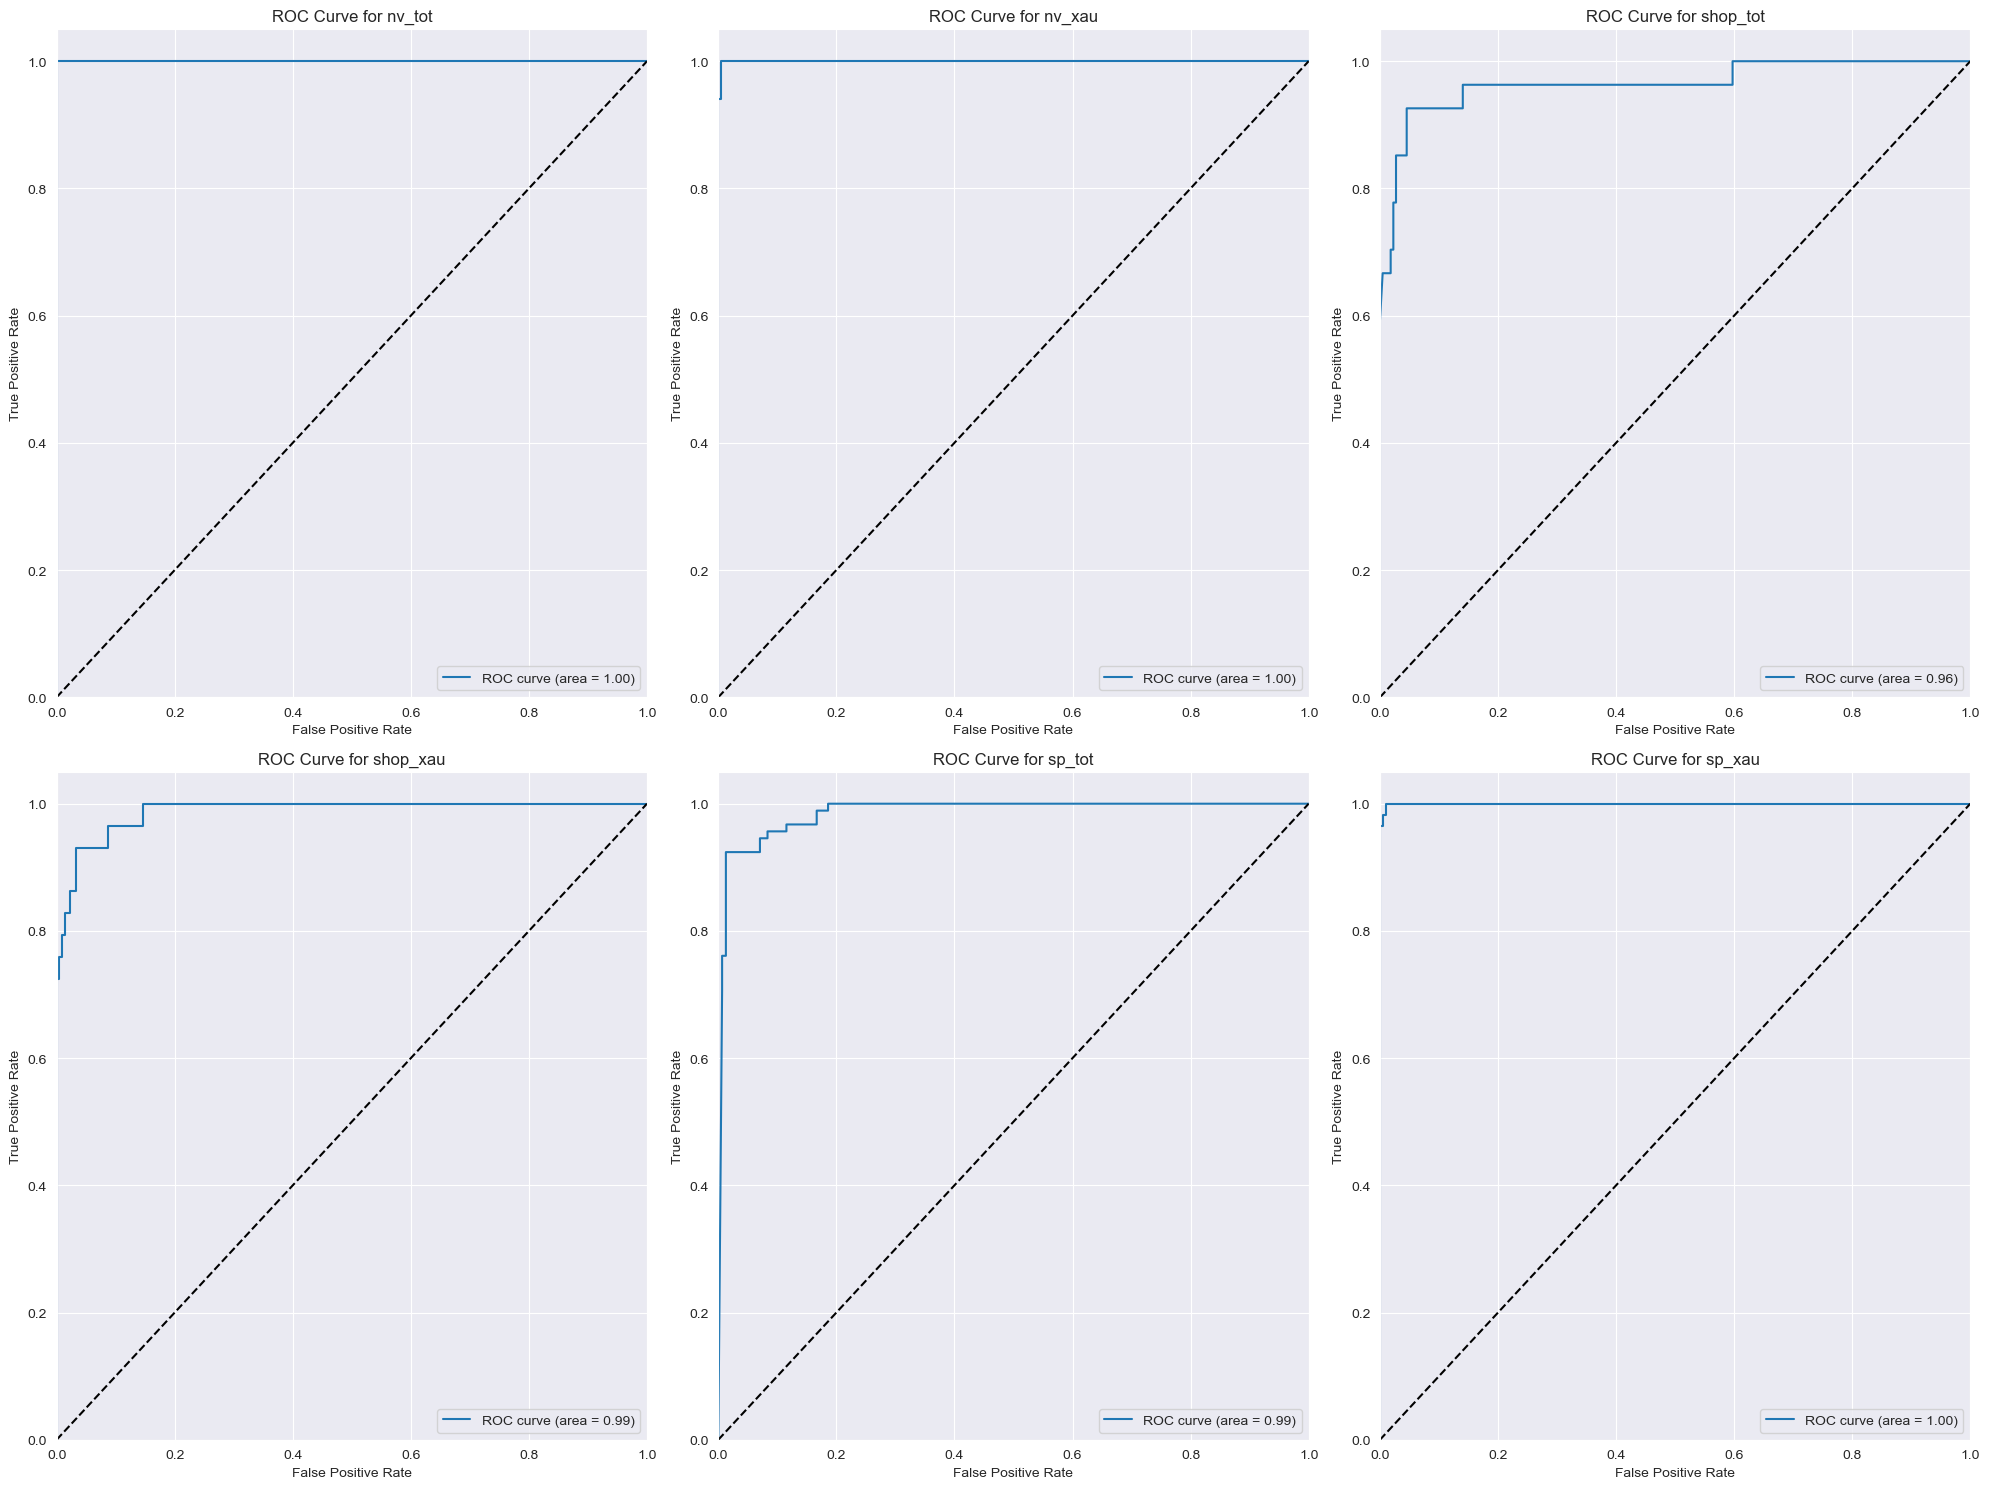

In [32]:
def plot_multiclass_roc(model, test_dataset, n_classes):
    
    y_true = []
    y_pred = []
    
    for feature, labels in test_dataset:
        y_true.append(labels.numpy())
        y_pred.append(model.predict(feature, verbose=False))
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    
    if y_true.ndim == 1 or y_true.shape[1] != n_classes:
        y_true = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)

    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    fig, axes = plt.subplots(2, 3, figsize=(20, 15))
    axes = axes.ravel()

    for i in range(n_classes):
        axes[i].plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f})')
        axes[i].plot([0, 1], [0, 1], 'k--')
        axes[i].set_xlim([0.0, 1.0])
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlabel('False Positive Rate')
        axes[i].set_ylabel('True Positive Rate')
        axes[i].set_title(f'ROC Curve for {CLASS_NAMES[i]}')
        axes[i].legend(loc="lower right")
    
    # Hide any unused subplots if n_classes < 6
    for i in range(n_classes, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()
plot_multiclass_roc(model, test_ds, len(CLASS_NAMES))

## 9.4 Confusion Matrix

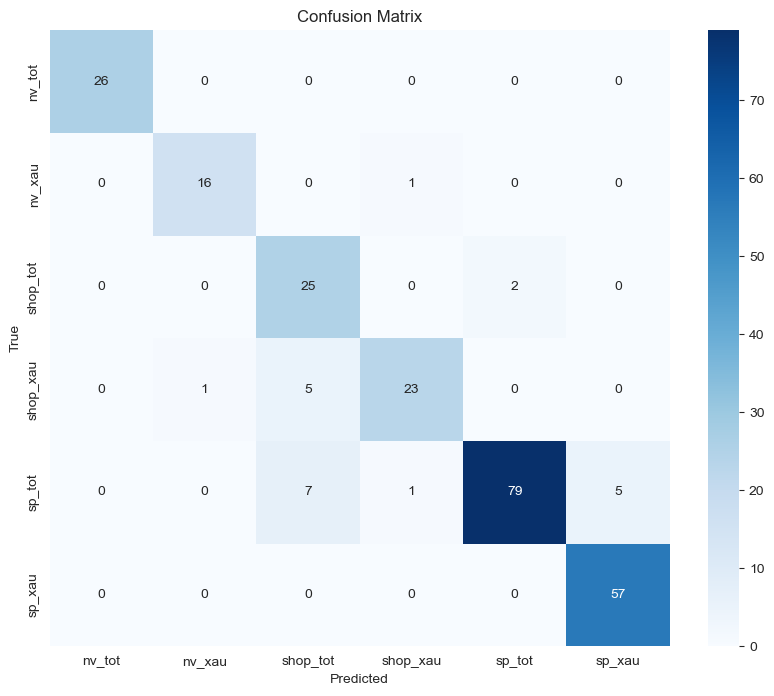

In [33]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
def visualize_confusion_matrix(model, dataset, class_names):
    
    true_labels = []
    predictions = []
    
    for features, labels in dataset:
        preds = model.predict(features, verbose=False)
        true_labels.extend(labels.numpy())
        predictions.extend(np.argmax(preds, axis=1))
    
    if len(true_labels) > 0 and len(true_labels[0]) > 1:
        true_labels = np.argmax(true_labels, axis=1)
    
    cm = confusion_matrix(true_labels, predictions)
    
    plot_confusion_matrix(cm, class_names)
    
    
visualize_confusion_matrix(model, test_ds, CLASS_NAMES)

# 10. Save model

In [34]:
model_path = "./SavedModel"

## 10.1. Export and save weights of model

In [35]:
model.save(f"{model_path}/{model.name}.h5")
model.export(f"{model_path}/{model.name}")

INFO:tensorflow:Assets written to: ./SavedModel/sentiments_model\assets


INFO:tensorflow:Assets written to: ./SavedModel/sentiments_model\assets


Saved artifact at './SavedModel/sentiments_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 293), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  1388103794768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1388739676112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1388739675728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1388822018192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1388728329680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1388822018384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1388822019920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1388822018960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1388852314768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1388852314576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1388852315728: TensorSpec(shape=(), 

In [36]:
def cls_comment(cmt):
    feature = tokenizer.encode_plus(cmt,
    add_special_tokens=True,
    padding='max_length',      
    max_length=max_length, return_tensors='tf')['input_ids'].numpy()
    feature = feature[0][:, np.newaxis]
    feature = tf.expand_dims(feature, axis=0)
    pred = model.predict(feature, verbose=False)
    cls = pred.argmax(axis=1)
    print(CLASS_NAMES[int(cls)])
    
cls_comment("Đầm mỏng nhẹ, mặc lên vừa vặn đẹp. Chất liệu thoáng mát, mặc vào ko bị nóng. Đóng gói cẩn thận. Cảm ơn shop, sẽ ủng hộ sản phẩm tiếp theo.")

sp_tot


C:\Users\ad\AppData\Local\Temp\ipykernel_8316\2213204085.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(CLASS_NAMES[int(cls)])


In [58]:
classifier = keras.models.load_model("./SavedModel/sentiments_model.h5")

<Functional name=sentiments_model, built=True>